# Hyperbolic unitary cost function ADAM gradient descent on MPO 

Created 04/11/2024

Objectives:
* Investigate convergence of unitary cost grad descent on MPO with a "hyperbolic" unitary cost function.

# Package imports

In [1]:
import sys

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from functools import reduce

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import re

# Load data

In [6]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [7]:
f_name = DATA_DIR + r"/0_90.h5"

In [8]:
f_name

'../../data/transverse_cluster_200_site_dmrg/0_90.h5'

In [9]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

In [10]:
NUM_SITES=5
BOND_DIMENSION=4
PHYSICAL_DIMENSION=2
LEARNING_RATE = 0.01

In [11]:
total_dimension = PHYSICAL_DIMENSION**NUM_SITES

In [12]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [13]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

In [14]:
def generate_random_w_tensor(dims):
    x1 = np.random.rand(*dims)
    x2 = 1j*np.random.rand(*dims)

    return x1 + x2

In [15]:
edge_dims = [PHYSICAL_DIMENSION,]*2 + [BOND_DIMENSION,]
inner_dims = edge_dims + [BOND_DIMENSION,]

In [16]:
w = generate_random_w_tensor(edge_dims)

In [17]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vR'])

In [18]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>

In [19]:
w_tensors = [w_tensor,]

In [20]:
for _ in range(NUM_SITES-2):
    w = generate_random_w_tensor(inner_dims)
    w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
    
    w_tensors.append(w_tensor)

In [21]:
w = generate_random_w_tensor(edge_dims)

In [22]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL'])

In [23]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>

In [24]:
w_tensors.append(w_tensor)

In [25]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

## Functions

In [26]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [27]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t.real

In [28]:
def order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [29]:
def order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

## Rescale tensor

In [30]:
mpo_frobenius_inner_product(w_tensors)

4255250.34079499

In [31]:
scale_factor = np.power(
    mpo_frobenius_inner_product(w_tensors).real,
    -1/(2*NUM_SITES)
)

In [32]:
scale_factor

0.21732389919541376

In [33]:
for w in w_tensors:
    w *= scale_factor

In [34]:
mpo_frobenius_inner_product(w_tensors)

0.9999999999999987

## Sweep function

In [35]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    leg_labels = raw_mpo_tensor.get_leg_labels()

    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [37]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     score_list,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]]):
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    ).real

    score_list.append(score)

    return score

In [40]:
def tolerant_square_root(x, tol=1e-5):
    if x >= 0:
        return np.sqrt(x)
    elif score_squared > -tol:
        return 0
    else:
        raise ValueError

In [114]:
def unitary_mpo_gradient_descent_sweep(mpo_tensors, learning_rate):
    """
    This code is a mess!
    """
    # Initialise variables
    right_two_tensors = order_two_right_tensors(mpo_tensors)
    right_four_tensors = order_four_right_tensors(mpo_tensors)

    left_two_tensors = list()
    left_four_tensors = list()

    order_two_scores = list()
    order_four_scores = list()

    num_sites = len(mpo_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    t = right_two_tensors[0]

    # Second order terms
    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    order_2_score = update_mpo_score(
        grad_2,
        w,
        order_two_scores,
        [['vL*',], ['vR*',]]
    )

    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    # Fourth order terms
    t = right_four_tensors[0]

    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    order_4_score = update_mpo_score(
        grad_4,
        w,
        order_four_scores,
        [['vL1*',], ['vR*',]]
    )

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    unitary_score = order_4_score - 2*order_2_score + total_dimension

    grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)

    # Update tensor
    mpo_tensors[0] = w - learning_rate*grad

    # Create and save left tensors
    w = mpo_tensors[0]

    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_two_tensors.append(t)
    
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    left_four_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w=mpo_tensors[i]
        right_two_tensor = right_two_tensors[i]
        right_four_tensor = right_four_tensors[i]

        # Order two terms
        left_two_tensor = left_two_tensors[-1]

        grad_2 = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_2 = npc.tensordot(grad_2, left_two_tensor, [['vL'], ['vR',]])

        order_2_score = update_mpo_score(
            grad_2,
            w,
            order_two_scores
        )
        grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

        # Order four terms
        left_four_tensor = left_four_tensors[-1]

        grad_4 = npc.tensordot(right_four_tensor, w, [['vL'], ['vR',]])
        grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
        grad_4 = npc.tensordot(
            grad_4,
            w.replace_label('vL', 'vL1'),
            [['vL1', 'p'], ['vR', 'p*']]
        )
        
        grad_4 = npc.tensordot(
            grad_4,
            left_four_tensor,
            [['vL', 'vL*', 'vL1'], ['vR', 'vR*', 'vR1']]
        )

        order_4_score = update_mpo_score(
            grad_4,
            w,
            order_four_scores,
            [['vL1*', 'vR1*',], ['vR*', 'vL*',]]
        )
        grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

        unitary_score = order_4_score - 2*order_2_score + total_dimension

        grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)
    
        # Update tensor
        mpo_tensors[i] = w - learning_rate*grad

        w = mpo_tensors[i]

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_two_tensors.append(t)
        
        t = npc.tensordot(left_four_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(t, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vR1'),
            [['p', 'vR1'], ['p*', 'vL']]
        )
        t = npc.tensordot(
            t,
            w.conj().replace_label('vR*', 'vR1*'),
            [['p', 'p*', 'vR1*'], ['p*', 'p', 'vL*']]
        )
        
        left_four_tensors.append(t)

    # Last site
    left_two_tensor = left_two_tensors[-1]
    w = mpo_tensors[-1]
    
    grad_2 = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    
    order_2_score = update_mpo_score(
        grad_2,
        w,
        order_two_scores,
        [['vR*',], ['vL*',]]
    )
    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    left_four_tensor = left_four_tensors[-1]
    
    grad_4 = npc.tensordot(left_four_tensor, w, [['vR'], ['vL',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vR1', 'p'], ['vL', 'p*']])
    
    order_4_score = update_mpo_score(
        grad_4,
        w,
        order_four_scores,
        [['vR1*',], ['vL*',]]
    )
    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    unitary_score = order_4_score - 2*order_2_score + total_dimension

    grad = (grad_4 - grad_2)/np.sqrt(1+unitary_score)

    # Update tensor
    mpo_tensors[-1] = w - learning_rate*grad

    return (order_two_scores, order_four_scores)

In [99]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [100]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

### Rescale and get mpo tensors

In [101]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [102]:
def get_random_mpo_tensors(num_sites=NUM_SITES, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

### Identity w_tensors

In [103]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [104]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

# Analysis

## Quick test

In [285]:
w_tensors = get_random_mpo_tensors(norm=1)

In [286]:
mpo_frobenius_inner_product(w_tensors)

0.9999999999999993

In [287]:
learning_rate = 0.05
unitarity_errors = list()
num_iterations = 500

In [288]:
total_dimension = 2**NUM_SITES

In [289]:
for _ in range(num_iterations):
    o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

    unitarity_errors.append(
        unitarity_errors_from_subscores(o2, o4, total_dimension)
    )

In [290]:
unitary_errors_array = np.array(unitarity_errors)

In [291]:
unitary_errors_array

array([[3.08362314e+01, 3.08334068e+01, 3.08327771e+01, 3.08321201e+01,
        3.08313706e+01],
       [3.08270610e+01, 3.08243622e+01, 3.08237784e+01, 3.08231696e+01,
        3.08224698e+01],
       [3.08181377e+01, 3.08155389e+01, 3.08149951e+01, 3.08144284e+01,
        3.08137715e+01],
       ...,
       [5.14320341e-03, 5.01753337e-03, 5.12581145e-03, 5.10551026e-03,
        5.10507835e-03],
       [5.10470761e-03, 4.98274314e-03, 5.10933050e-03, 5.08658390e-03,
        5.08612801e-03],
       [5.08576836e-03, 4.96802305e-03, 5.11576981e-03, 5.09092294e-03,
        5.09046703e-03]])

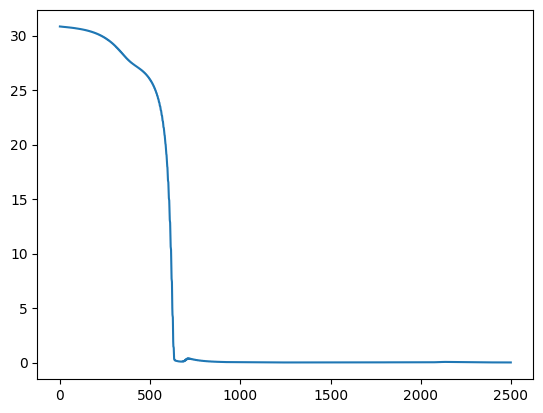

In [292]:
plt.plot(unitary_errors_array.flatten())

In [293]:
unitary_errors_array[-1]

array([0.00508577, 0.00496802, 0.00511577, 0.00509092, 0.00509047])

## Learning rates & initial norm

### Sweep 1

In [272]:
num_iterations = 1000
num_sites = 5
total_dimension = 2**num_sites

In [273]:
total_dimension

32

In [274]:
initial_norms

[1, 5.656854249492381, 32]

In [275]:
learning_rates = [0.3, 0.5, 0.7]
initial_norms = [1, np.sqrt(total_dimension), total_dimension]

In [276]:
array_shape = (
    len(learning_rates),
    len(initial_norms),
    num_iterations,
    num_sites
)

unitary_errors_array = np.zeros(array_shape)

In [277]:
for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        print((i_lr, i_norm))
        
        w_tensors = get_random_mpo_tensors(NUM_SITES, norm)
        
        for i_iteration in range(num_iterations):
            o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)
        
            unitarity_errors = unitarity_errors_from_subscores(
                o2, o4, total_dimension
            )

            unitary_errors_array[i_lr, i_norm, i_iteration] = unitarity_errors

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67676/198488462.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


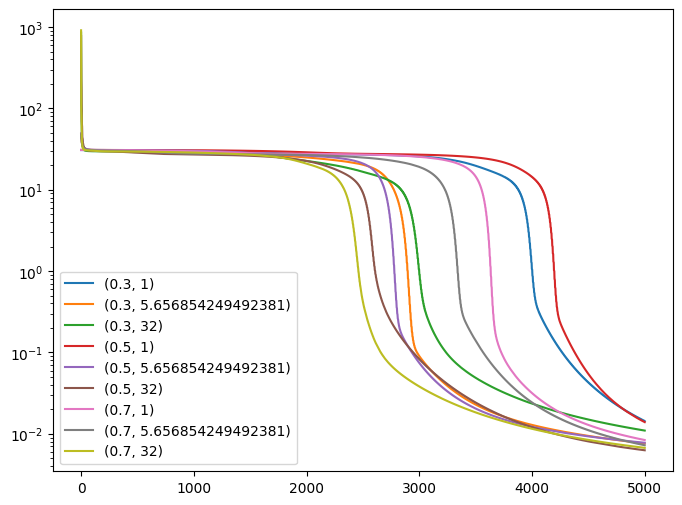

In [278]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        label = f"({lr}, {norm})"
        ax.plot(
            unitary_errors_array[i_lr, i_norm].flatten(),
            label=label
        )

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67676/2902148041.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


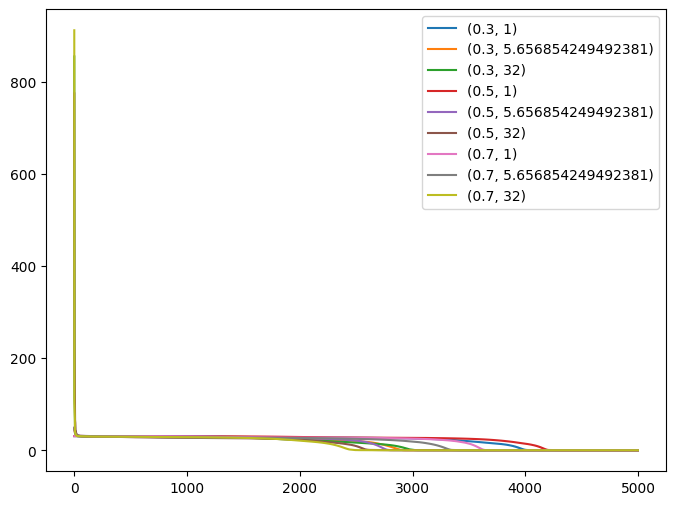

In [279]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        label = f"({lr}, {norm})"
        ax.plot(
            unitary_errors_array[i_lr, i_norm].flatten(),
            label=label
        )

#ax.set_ylim(2*total_dimension)
#ax.set_yscale('log')

ax.legend()

fig.show()

In [284]:
unitary_errors_array[...,-1,-1]

array([[0.0143328 , 0.00760944, 0.0109701 ],
       [0.01392992, 0.007766  , 0.00627877],
       [0.00838971, 0.00723443, 0.00672338]])

Converging over a large range of learning rates/initial norms!

### Sweep 2

In [295]:
learning_rates = [0.01, 0.03, 0.1]
initial_norms = [0.01, 0.1, 1]

In [296]:
array_shape = (
    len(learning_rates),
    len(initial_norms),
    num_iterations,
    num_sites
)

unitary_errors_array = np.zeros(array_shape)

In [297]:
for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        print((i_lr, i_norm))
        
        w_tensors = get_random_mpo_tensors(NUM_SITES, norm)
        
        for i_iteration in range(num_iterations):
            o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)
        
            unitarity_errors = unitarity_errors_from_subscores(
                o2, o4, total_dimension
            )

            unitary_errors_array[i_lr, i_norm, i_iteration] = unitarity_errors

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67676/198488462.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


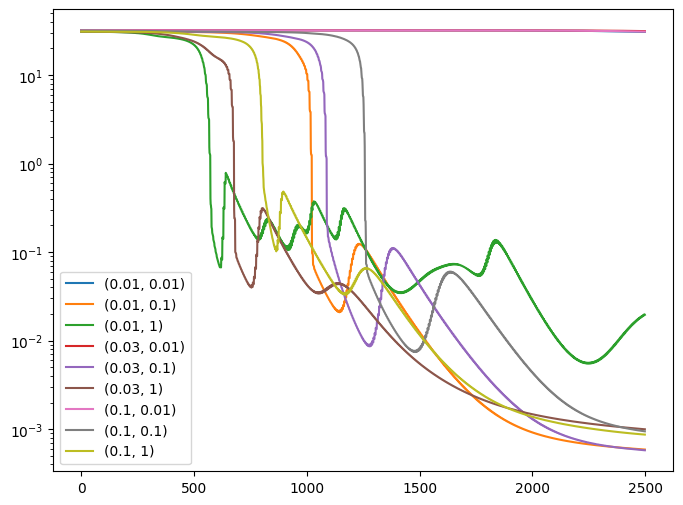

In [298]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        label = f"({lr}, {norm})"
        ax.plot(
            unitary_errors_array[i_lr, i_norm].flatten(),
            label=label
        )

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67676/2048262471.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


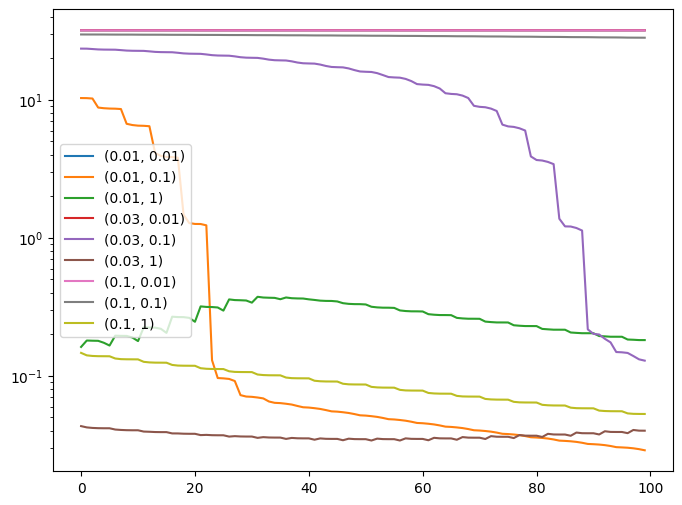

In [299]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        label = f"({lr}, {norm})"
        ax.plot(
            unitary_errors_array[i_lr, i_norm].flatten()[1000:1100],
            label=label
        )

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

In [304]:
partial_flat_unitary_errors_array = np.reshape(
    unitary_errors_array,
    (*unitary_errors_array.shape[:2], -1)
)

In [305]:
partial_flat_unitary_errors_array.shape

(3, 3, 2500)

In [310]:
delta = partial_flat_unitary_errors_array[...,1:] - partial_flat_unitary_errors_array[...,:-1]

In [311]:
delta.shape

(3, 3, 2499)

In [312]:
pos_delta = delta>0

In [313]:
pos_delta

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [314]:
pos_delta.shape

(3, 3, 2499)

In [315]:
np.sum(pos_delta, axis=-1)

array([[  0,  25, 551],
       [  0,  30,  49],
       [  0,  46,  74]])

In [316]:
np.sum(pos_delta[...,::5], axis=-1)

array([[  0,  25, 128],
       [  0,  30,  15],
       [  0,  46,   9]])

In [317]:
np.sum(pos_delta[...,1::5], axis=-1)

array([[  0,   0, 205],
       [  0,   0,  34],
       [  0,   0,  29]])

In [318]:
np.sum(pos_delta[...,2::5], axis=-1)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [319]:
np.sum(pos_delta[...,3::5], axis=-1)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [320]:
np.sum(pos_delta[...,4::5], axis=-1)

array([[  0,   0, 218],
       [  0,   0,   0],
       [  0,   0,  36]])

So when the cost function increases, it only occurs at the inside/outside mpo tensors. Not a smooth increase. The waves are still strange as over a sweep over all sites, the total cost function can still increase, but eventually the increase plateaus.

Would this problem be solved by a smaller learning rate? It should be!

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67676/2902148041.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


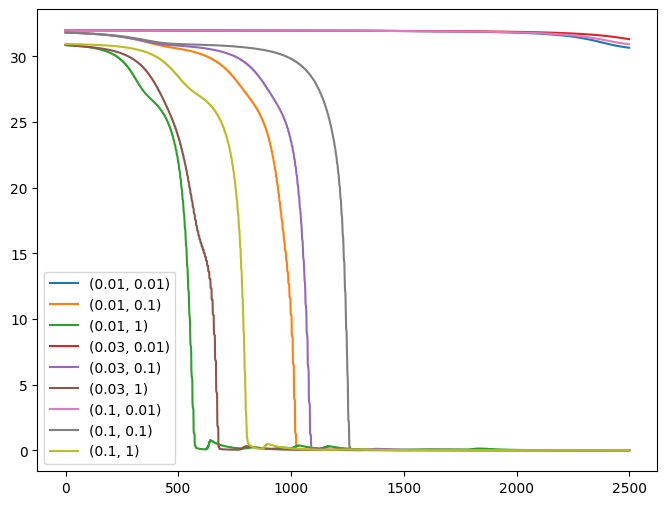

In [300]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        label = f"({lr}, {norm})"
        ax.plot(
            unitary_errors_array[i_lr, i_norm].flatten(),
            label=label
        )

#ax.set_ylim(2*total_dimension)
#ax.set_yscale('log')

ax.legend()

fig.show()

## Num sites
Sweep over a range of the number of sites

### Sweep 1

In [348]:
learning_rate = 0.05

num_sites_list = list(range(2, 12))

In [349]:
num_iterations = 1000

In [350]:
unitary_errors_arrays = list()

for n in num_sites_list:
    unitary_errors_arrays.append(np.zeros((num_iterations, n)))

In [351]:
for i_num_sites, num_sites in enumerate(num_sites_list):
    print((i_num_sites, num_sites))
    
    w_tensors = get_random_mpo_tensors(num_sites, 2**num_sites)
    
    for i_iteration in range(num_iterations):
        o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

        total_dimension = 2**num_sites
        unitarity_errors = unitarity_errors_from_subscores(
            o2, o4, total_dimension
        )

        unitary_errors_arrays[i_num_sites][i_iteration] = unitarity_errors

(0, 2)
(1, 3)
(2, 4)
(3, 5)
(4, 6)
(5, 7)
(6, 8)
(7, 9)
(8, 10)
(9, 11)


In [352]:
unitary_errors_arrays[-1][-1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [353]:
unitary_errors_arrays[-2][-1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [354]:
unitary_errors_arrays[-3][-1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [355]:
unitary_errors_arrays[-4][-1]

array([nan, nan, nan, nan, nan, nan, nan, nan])

In [356]:
unitary_errors_arrays[-5][-1]

array([nan, nan, nan, nan, nan, nan, nan])

In [357]:
unitary_errors_arrays[-7][-1]

array([0.00056628, 0.00056611, 0.0005659 , 0.00056566, 0.00056552])

In [358]:
unitary_errors_arrays[-6][-1]

array([nan, nan, nan, nan, nan, nan])

In [359]:
unitary_errors_arrays[-8][-1]

array([0.00022954, 0.00022925, 0.00022916, 0.00022902])

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67676/3820952185.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


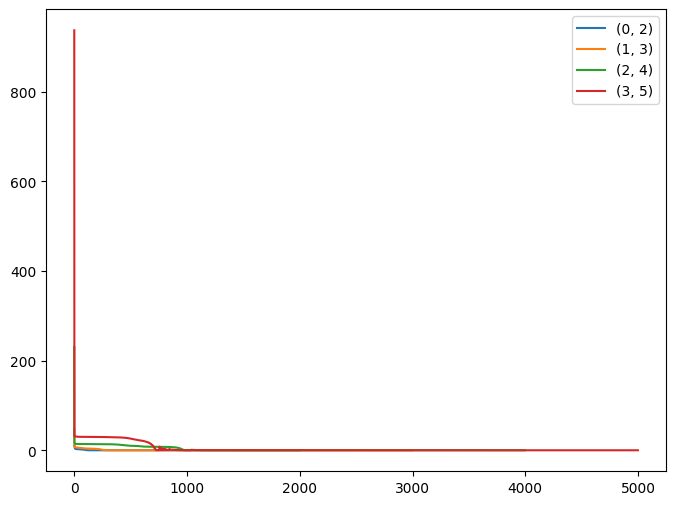

In [363]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, num_sites in enumerate(num_sites_list[:4]):
    label = f"({i}, {num_sites})"
    ax.plot(
        unitary_errors_arrays[i].flatten(),
        label=label
    )

#ax.set_ylim(2*total_dimension)
#ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67676/2785911000.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


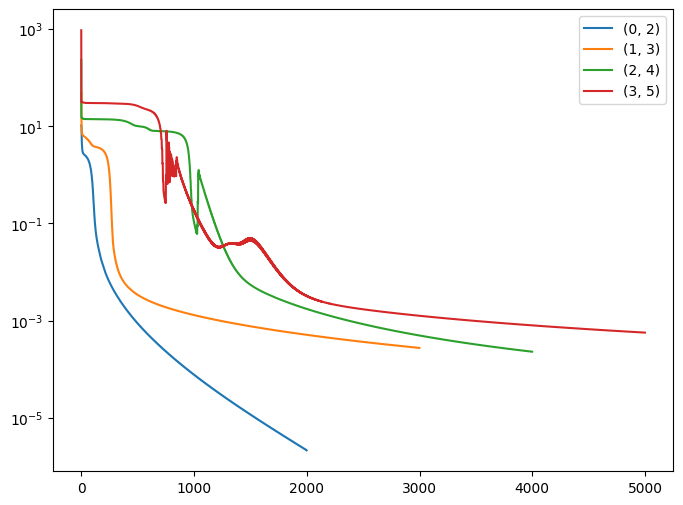

In [364]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, num_sites in enumerate(num_sites_list[:4]):
    label = f"({i}, {num_sites})"
    ax.plot(
        unitary_errors_arrays[i].flatten(),
        label=label
    )

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67676/3757407235.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


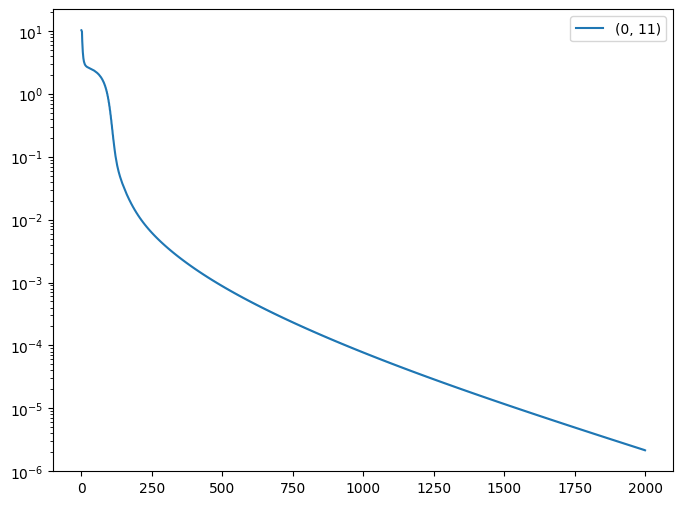

In [367]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, num_sites in enumerate(num_sites_list[4:][5:]):
    label = f"({i}, {num_sites})"
    ax.plot(
        unitary_errors_arrays[i].flatten(),
        label=label
    )

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67676/3687117692.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


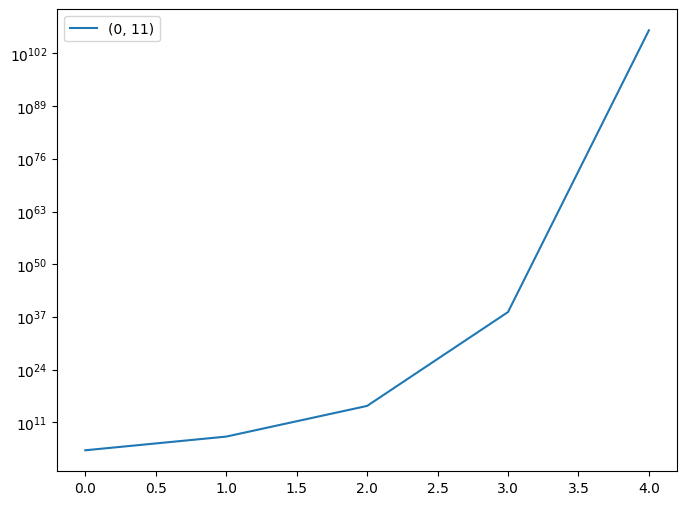

In [370]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(
    unitary_errors_arrays[5].flatten(),
    label=label
)

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_67676/3967722950.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


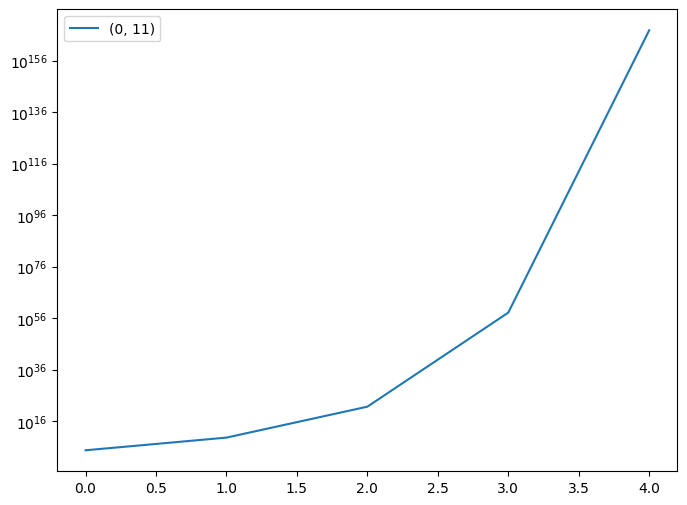

In [371]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(
    unitary_errors_arrays[6].flatten(),
    label=label
)

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

Picking the right learning rate is hard for various number of sites, and there is a tendency to still diverge...! Although this may be partially fixed by initially setting renormalising the mpo.

## Large num sites, sweep learning rate

In [372]:
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]

num_sites = 10

In [373]:
num_iterations = 50

In [375]:
unitary_errors_arrays = list()

for lr in learning_rates:
    unitary_errors_arrays.append(np.zeros((num_iterations, num_sites)))

In [376]:
for i, lr in enumerate(learning_rates):
    
    w_tensors = get_random_mpo_tensors(num_sites, 2**num_sites)
    
    for i_iteration in range(num_iterations):
        o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, lr)

        total_dimension = 2**num_sites
        unitarity_errors = unitarity_errors_from_subscores(
            o2, o4, total_dimension
        )

        unitary_errors_arrays[i][i_iteration] = unitarity_errors

In [377]:
unitary_errors_arrays[-1][-1]

array([1021.31533908, 1021.30642766, 1021.30594218, 1021.30588754,
       1021.30586466, 1021.30584693, 1021.30582164, 1021.30580676,
       1021.30579202, 1021.30576998])

In [381]:
unitary_errors_arrays[-2][-1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Go from slow convergence to divergence in a very small learning rate space!

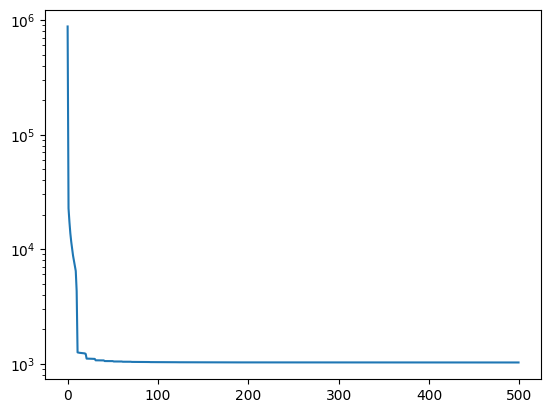

In [385]:
plt.plot(unitary_errors_arrays[-1].flatten())
plt.yscale('log')

### Smaller learning rate

In [414]:
learning_rate = 0.002

num_sites = 10

In [417]:
num_iterations = 100000

In [418]:
unitary_errors_array = np.zeros((num_iterations, num_sites))

In [419]:
w_tensors = get_random_mpo_tensors(num_sites, 2**num_sites)

for i_iteration in range(num_iterations):
    if (i_iteration % 1000) == 0:
        print(i_iteration)

    o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

    total_dimension = 2**num_sites
    unitarity_errors = unitarity_errors_from_subscores(
        o2, o4, total_dimension
    )

    unitary_errors_array[i_iteration] = unitarity_errors

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [420]:
unitary_errors_array[-1]

array([0.11566481, 0.11549623, 0.11544087, 0.11541723, 0.11542055,
       0.11540929, 0.11540749, 0.11538634, 0.11362218, 0.11568991])

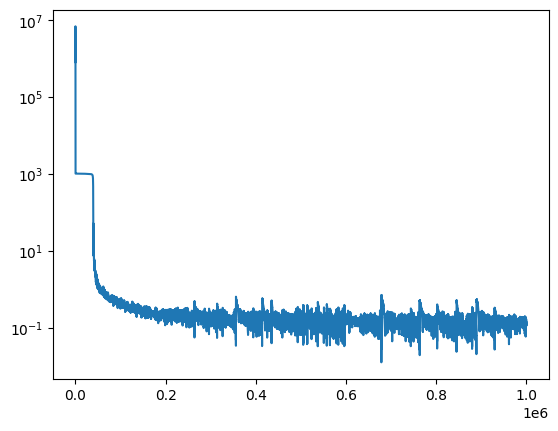

In [421]:
plt.plot(unitary_errors_array.flatten())

plt.yscale('log')

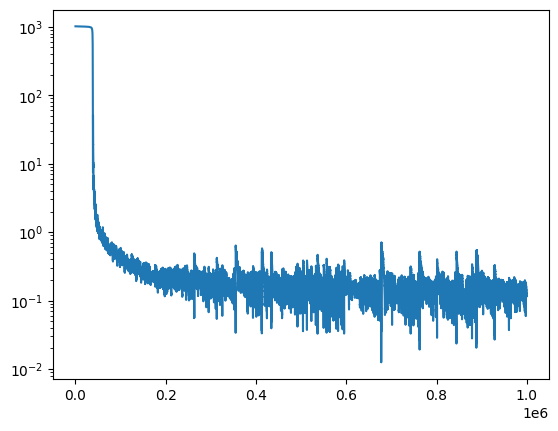

In [422]:
plt.plot(unitary_errors_array[100:].flatten())

plt.yscale('log')

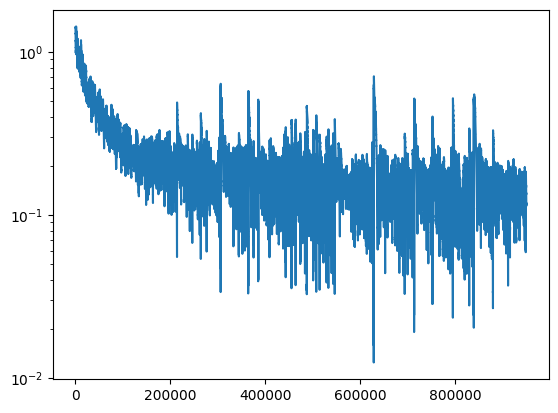

In [430]:
plt.plot(unitary_errors_array[5000:].flatten())

plt.yscale('log')

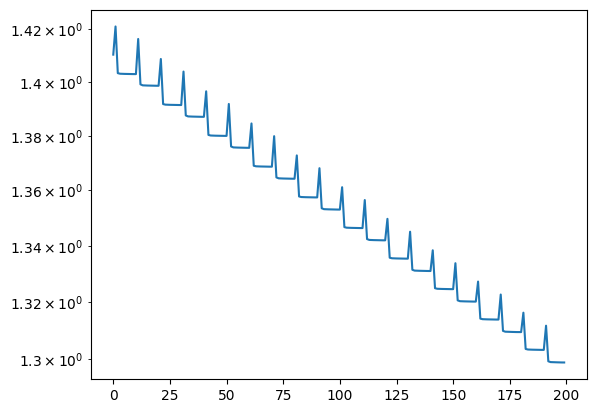

In [434]:
plt.plot(unitary_errors_array[5000:5020].flatten())

plt.yscale('log')

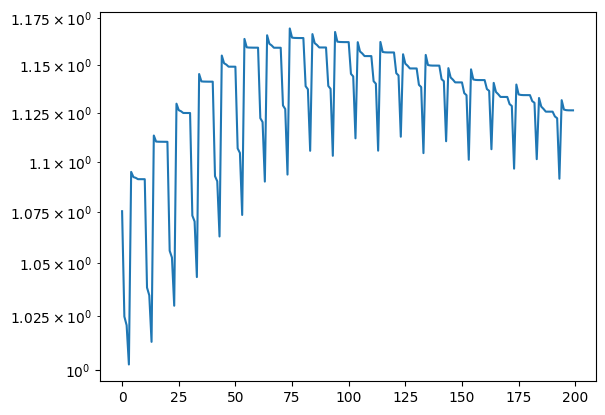

In [435]:
plt.plot(unitary_errors_array[5100:5120].flatten())

plt.yscale('log')

Get convergence eventually, but the cost function is still noisy. Learning rate still too big?

### Even smaller learning rate

In [437]:
learning_rate = 0.0005

num_sites = 10

In [438]:
num_iterations = 50000

In [439]:
unitary_errors_array = np.zeros((num_iterations, num_sites))

In [440]:
w_tensors = get_random_mpo_tensors(num_sites, 2**num_sites)

for i_iteration in range(num_iterations):
    if (i_iteration % 1000) == 0:
        print(i_iteration)

    o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

    total_dimension = 2**num_sites
    unitarity_errors = unitarity_errors_from_subscores(
        o2, o4, total_dimension
    )

    unitary_errors_array[i_iteration] = unitarity_errors

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [441]:
unitary_errors_array[-1]

array([0.00339423, 0.00339423, 0.00339422, 0.00339421, 0.00339419,
       0.00339417, 0.00339414, 0.00339412, 0.00339411, 0.00339409])

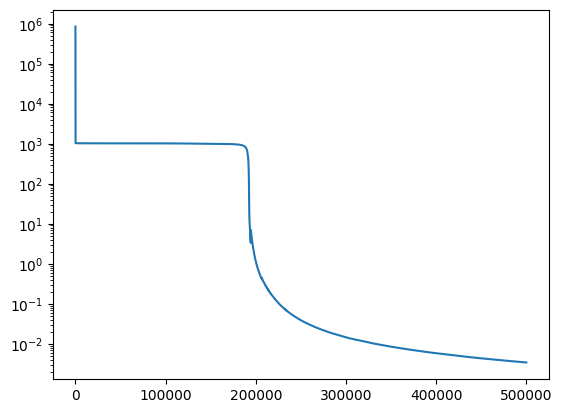

In [442]:
plt.plot(unitary_errors_array.flatten())

plt.yscale('log')

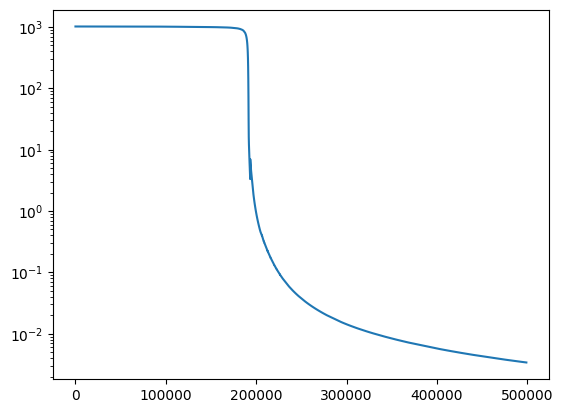

In [443]:
plt.plot(unitary_errors_array[100:].flatten())

plt.yscale('log')

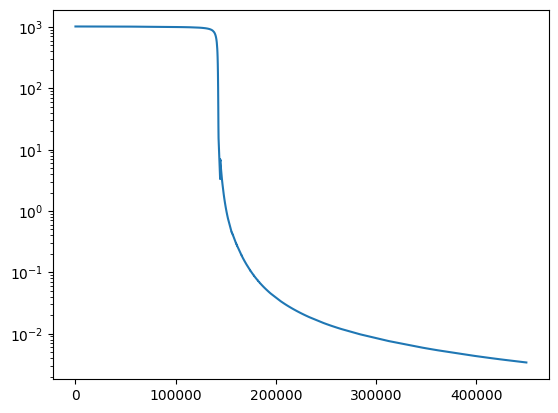

In [444]:
plt.plot(unitary_errors_array[5000:].flatten())

plt.yscale('log')

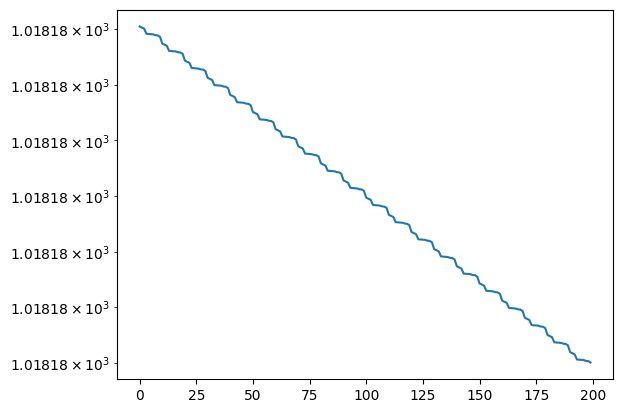

In [445]:
plt.plot(unitary_errors_array[5000:5020].flatten())

plt.yscale('log')

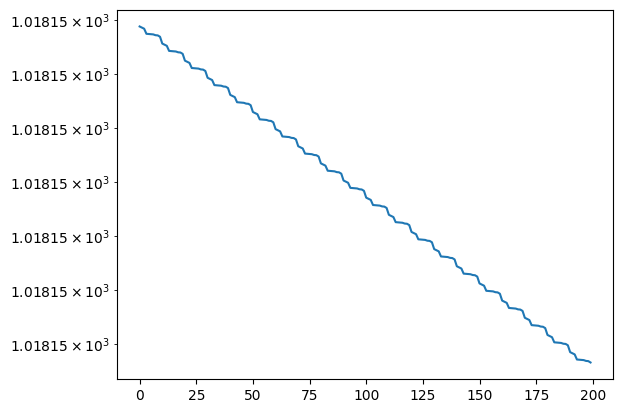

In [446]:
plt.plot(unitary_errors_array[5100:5120].flatten())

plt.yscale('log')

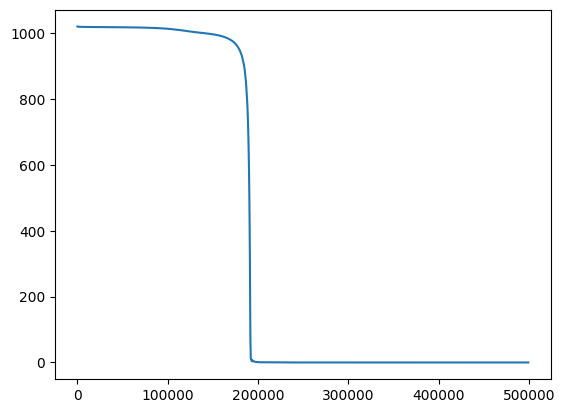

In [447]:
plt.plot(unitary_errors_array[100:].flatten())

#plt.yscale('log')

Nice and smooth, good convergence, and still room for improvement.

# Conclusions
* The hyperbolic cost function does seem to be working in reducing the number of divergences that happen.
* However with a large number of sites, the gd algo is sensitive to the learning rate. Divergences still happen.
    * Possibly fixed by normalising correctly?
* Further it can be hard to figure out the right learning rate to use due to a plateau!
    * This suggests using Adam, or another GD algorithm.